In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [533]:
AAPL = pd.read_csv("hist_data/AAPL.csv")
MSFT = pd.read_csv("hist_data/MSFT.csv")

In [546]:
AAPL

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-05-23,23.967501,24.297501,23.917500,24.107500,22.520861,152074400
1,2016-05-24,24.305000,24.522499,24.209999,24.475000,22.864182,140560800
2,2016-05-25,24.667500,24.934999,24.527500,24.905001,23.265877,152675200
3,2016-05-26,24.920000,25.182501,24.660000,25.102501,23.450378,225324800
4,2016-05-27,24.860001,25.117500,24.812500,25.087500,23.436363,145364800
...,...,...,...,...,...,...,...
1254,2021-05-17,126.820000,126.930000,125.169998,126.269997,126.269997,74244600
1255,2021-05-18,126.559998,126.989998,124.779999,124.849998,124.849998,63342900
1256,2021-05-19,123.160004,124.919998,122.860001,124.690002,124.690002,92612000
1257,2021-05-20,125.230003,127.720001,125.099998,127.309998,127.309998,76857100


In [598]:
def prices2returns(prices):
    return np.array([(prices[i+1] - prices[i]) / prices[i] for i in range(len(prices)-1)])

def returns2prices(p0, returns):
    if len(returns.shape) == 1:
        L = returns.shape[0];
        prices = np.zeros(L+1)
        prices[0] = p0

        for i in range(L):
            prices[i+1] = prices[i] + prices[i] * returns[i]
    else:
        prices = np.array([returns2prices(p0, r) for r in returns])
    
    return prices[1:]
        
class BaseModel:
    def __init__(self, data=None):
        self.prices = data['Close'].to_numpy()
        self.data = data
        self.returns = None
        self.pseudo_returns = None
        self.T = 0
        self.date_format = "%Y-%m-%d"
        self.dates = [datetime.datetime.strptime(date, self.date_format).date() for date in self.data['Date'][:]]
    
    def get_returns(self, T, F=0):
        prices = self.prices[F:T]
        self.returns = prices2returns(prices)
        self.T = T
    
    def extend_returns(self, S):
        prices = self.prices[self.T-1:self.T+S]
        self.returns = np.append(self.returns, prices2returns(prices))
        self.T += S
    
    def simulate(self, steps, trials, T=None, F=0):
        self.pseudo_returns = np.zeros([trials, steps])
        
    def plot_last_simulation(self, N=10, padding=10, real_price=False, axis='dates'):
        steps = self.pseudo_returns.shape[1]
        p0 = self.prices[self.T-1]
        if steps <= 0: return
        
        plt.figure(figsize=(10,5))
        plt.grid(True)
        
        end = self.T+steps if real_price else self.T 
        if axis == 'dates': 
            axis_simulated = self.dates[self.T-1:self.T+steps]
            axis_real = self.dates[self.T-padding:end]
        elif axis == 'numbers':
            axis_real = np.arange(self.T-padding, end)
            axis_simulated = np.arange(self.T-1, self.T+steps)
            
        simulated_prices = returns2prices(p0, self.pseudo_returns[np.random.randint(self.pseudo_returns.shape[0], size=N), :])
        
        for sp in simulated_prices:
            sp = np.append(np.array([p0]), sp)
            plt.plot(axis_simulated, sp, color='green', linewidth=0.2)
            
        print(self.dates[self.T-1], self.dates[self.T+steps], steps)
            
        plt.plot(axis_real, self.prices[self.T-padding:end], color='blue', linewidth=2)
            
        
    def plot(self, begin=0, end=None, axis='dates'):
        if not end: end = len(self.prices)
            
        if axis == 'dates': 
            axis = self.dates[begin:end]
        elif axis == 'numbers':
            axis = np.arange(begin,end)

        plt.figure(figsize=(10,5))
        plt.grid(True)
        plt.plot(axis, self.prices[begin:end])
    
    def VaR(self, q):
        simulated_prices = returns2prices(self.prices[self.T-1], self.pseudo_returns)
        level = simulated_prices[simulated_prices[:,-1].argsort()[int(q * len(simulated_prices)) + 1]][-1]
        p0 = self.prices[self.T-1]
        var = (level - p0) / p0
        return var, level
    
    def evaluate(self, F, T, E, S, q, steps, trials, plot_errors=False):
        error = 0
        total = 0
        
        for i in range(T, E-max(steps, S), S):
            if i == T: self.get_returns(T, F)
            else: self.extend_returns(S)
            
            self.simulate(steps, trials)
            _, level = self.VaR(q)
            
            if self.prices[self.T+steps] < level: 
                error += 1
                if plot_errors: self.plot_last_simulation(50, real_price=True)
            total += 1
            
        return error/total
            
            

In [599]:
class RandomSampling(BaseModel):
    def __init__(self, data):
        super().__init__(data)
    
    def simulate(self, steps, trials, T=None, F=0):
        if T: self.get_returns(T, F)
        self.pseudo_returns = np.array([
            np.random.permutation(np.random.choice(self.returns, steps)) for _ in range(trials)
        ])
        return self.pseudo_returns

In [602]:
RS = RandomSampling(AAPL)
RS.evaluate(0, 365, 1200, 14, 0.01, 30, 500)

0.05172413793103448

2021-01-04 2021-02-18 30


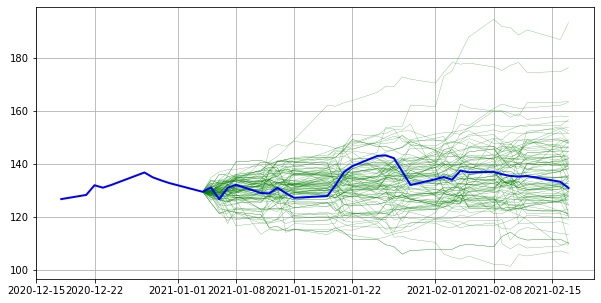

In [606]:
RS.plot_last_simulation(100, real_price=True)

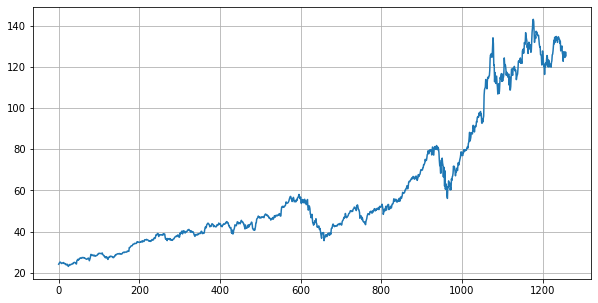

In [603]:
RS.plot(axis='numbers')

In [457]:
def a(x, y, z):
    print(x, y, z)

def b(x, y, z, *aargs):
    print(x, y, z)
    a(*aargs)

In [458]:
b(1, 2, 3, 4, 5, 6)

1 2 3
4 5 6


In [466]:
iii = 0
for iii in range(5):
    print("ok")
    
print(iii)

ok
ok
ok
ok
ok
4
